# Analyze CSV data files with Vanna

world top companies
- https://www.kaggle.com/datasets/patricklford/largest-companies-analysis-worldwide
    -  https://www.kaggle.com/code/nil2012/top-company-key-metrics-analysis

## Setup

In [1]:
from glob import glob
import os
import re
from time import time
from datetime import datetime 

import pandas as pd
import sqlite3

from vanna.ollama import Ollama
from vanna.chromadb.chromadb_vector import ChromaDB_VectorStore

import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning, message='^Number of requested results')
# warnings.filterwarnings('ignore', category=DeprecationWarning, message=re.escape(r'^Some regex pattern'))

In [2]:
class MyVanna(ChromaDB_VectorStore, Ollama):
    def __init__(self, config=None):
        ChromaDB_VectorStore.__init__(self, config=config)
        Ollama.__init__(self, config=config)

### load SQLite db with CSV data

In [3]:
file_db_path = "../data/company_rank.sqlite"
file_db = os.path.abspath(os.path.expanduser(file_db_path))
print(file_db)

/home/gongai/projects/wgong/py4kids/lesson-18-ai/vanna/note_book/data/company_rank.sqlite


In [4]:
LOAD_CSV = True # False
if LOAD_CSV:
    csv_files = glob("../data/company_rank/*.csv")
    print(csv_files)
    
    conn = sqlite3.connect(file_db)
    df_dict = {}
    col_map = {}
    for i in csv_files:
        t = i.split("/")[-1].lower().replace("companies_ranked_by_","").replace(".csv","")
        df = pd.read_csv(i)
        c_map = {c:c.lower() for c in df.columns}
        c_map['price (GBP)'] = 'price_gbp'
        # print(f"col_map: {c_map}")
        table_name = f"t_{t}"
        print(f"\n Loading data from file: '{i}' \n into table_name: '{table_name}'")
        col_map[table_name] = c_map
        df.rename(columns=c_map, inplace=True)
        df.to_sql(table_name, conn, if_exists='replace', index=False)
        df_dict[table_name] = df
    conn.close()

['../data/company_rank/Companies_ranked_by_P_E_ratio.csv', '../data/company_rank/Companies_ranked_by_Market_Cap.csv', '../data/company_rank/Companies_ranked_by_Dividend_Yield.csv', '../data/company_rank/Companies_ranked_by_Earnings.csv', '../data/company_rank/Companies_ranked_by_Revenue.csv', '../data/company_rank/country_region.csv']

 Loading data from file: '../data/company_rank/Companies_ranked_by_P_E_ratio.csv' 
 into table_name: 't_p_e_ratio'

 Loading data from file: '../data/company_rank/Companies_ranked_by_Market_Cap.csv' 
 into table_name: 't_market_cap'

 Loading data from file: '../data/company_rank/Companies_ranked_by_Dividend_Yield.csv' 
 into table_name: 't_dividend_yield'

 Loading data from file: '../data/company_rank/Companies_ranked_by_Earnings.csv' 
 into table_name: 't_earnings'

 Loading data from file: '../data/company_rank/Companies_ranked_by_Revenue.csv' 
 into table_name: 't_revenue'

 Loading data from file: '../data/company_rank/country_region.csv' 
 into ta

In [5]:
# verify
VERIFY_DB = True # False # 
if VERIFY_DB:
    conn = sqlite3.connect(file_db)
    sql_stmt = f"select name from {table_name} limit 10"
    sql_stmt = """ 
    select country from t_revenue
     UNION 
    select country from t_earnings
     UNION 
    select country from t_market_cap
     UNION 
    select country from t_p_e_ratio
     UNION 
    select country from t_dividend_yield
    """
    df_2 = pd.read_sql_query(sql_stmt, conn).fillna("")
    country_list = df_2["country"].to_list()
    # print(df_2)
    conn.close()

In [6]:
country_list

['',
 'Argentina',
 'Australia',
 'Austria',
 'Bahamas',
 'Bahrain',
 'Belgium',
 'Bermuda',
 'Brazil',
 'British Virgin Islands',
 'Cambodia',
 'Canada',
 'Cayman Islands',
 'Chile',
 'China',
 'Colombia',
 'Costa Rica',
 'Cyprus',
 'Czech Republic',
 'Denmark',
 'Egypt',
 'Estonia',
 'Finland',
 'France',
 'Germany',
 'Gibraltar',
 'Greece',
 'Guernsey',
 'Hong Kong',
 'Hungary',
 'Iceland',
 'India',
 'Indonesia',
 'Ireland',
 'Isle of Man',
 'Israel',
 'Italy',
 'Japan',
 'Jersey',
 'Jordan',
 'Kazakhstan',
 'Kuwait',
 'Lithuania',
 'Luxembourg',
 'Macau',
 'Malaysia',
 'Malta',
 'Mexico',
 'Monaco',
 'Netherlands',
 'New Zealand',
 'Nigeria',
 'Norway',
 'Oman',
 'Pakistan',
 'Panama',
 'Peru',
 'Philippines',
 'Poland',
 'Portugal',
 'Qatar',
 'Romania',
 'Russia',
 'Saudi Arabia',
 'Singapore',
 'South Africa',
 'South Korea',
 'Spain',
 'Sudan',
 'Sweden',
 'Switzerland',
 'Taiwan',
 'Thailand',
 'Turkey',
 'United Arab Emirates',
 'United Kingdom',
 'United States',
 'Uruguay'

### Fix country

### Setup LLM

In [7]:
model_name = 'deepseek-coder-v2'
config = {
    'model': model_name,   # 'mistral' # "starcoder2"
}

clean_and_train = True  # False  

sql_id = 1

allow_llm_to_see_data = True
# allow_llm_to_see_data (bool): Whether to allow the LLM to see the data (for the purposes of introspecting the data to generate the final SQL).

In [8]:
vn = MyVanna(config=config)

In [9]:
hostname = os.uname().nodename
print("Hostname:", hostname)

Hostname: ducklover1


In [10]:
# file_db = os.path.abspath(os.path.expanduser(file_db))
vn.connect_to_sqlite(file_db)

In [11]:
vn.run_sql_is_set

True

In [12]:
if clean_and_train:
    vn.remove_collections()

## Prepare Training Data

### Add DDL SQL statements

You only need to train once. Do not train again unless you want to add more training data.

In [13]:
df_ddl = vn.run_sql("SELECT type, sql FROM sqlite_master WHERE sql is not null")

In [14]:
df_ddl

,type,sql
0,table,"CREATE TABLE ""t_p_e_ratio"" (\n""rank"" INTEGER,\..."
1,table,"CREATE TABLE ""t_market_cap"" (\n""rank"" INTEGER,..."
2,table,"CREATE TABLE ""t_dividend_yield"" (\n""rank"" INTE..."
3,table,"CREATE TABLE ""t_earnings"" (\n""rank"" INTEGER,\n..."
4,table,"CREATE TABLE ""t_revenue"" (\n""rank"" INTEGER,\n ..."
5,table,"CREATE TABLE ""t_country_region"" (\n""country"" T..."


### Add business terms

In [15]:
business_docs = [
"""
Introduction:
This dataset ranks top companies in the world.
Its analysis delves into the financial performance of top companies by examining key metrics such as 
- revenue, 
- earnings, 
- market capitalisation, 
- P/E ratio, 
- dividend yield. 

By comparing these metrics, we gain a comprehensive understanding of a company's scale, 
profitability, market value, and growth potential. 
Through visualisations, the analysis also explores correlations between these metrics and offers 
insights into country-level performance, highlighting economic dominance across various sectors. 
This holistic approach provides a multi-dimensional view of global financial powerhouses, investor confidence, 
and regional economic trends.
""",

"""
Terminologies:
TTM : Trailing Twelve Months
PE : Price over Earning Raio
LOV : List-of-Values
""",

"""
Key Metrics 1. Revenue (TTM):
Table Name: t_revenue ;
Definition: This is the total income generated by a company from its operations in the last twelve months ;
Potential Insights: High revenue often indicates market dominance or high sales volume. Comparing revenues can reveal which companies are the largest in terms of business volume.
""",

"""
Key Metrics 2. Earnings (TTM):
Table Name: t_earnings
Definition: This refers to the company's profit after taxes and expenses over the trailing twelve months.
Potential Insights: Companies with high earnings are more efficient at converting revenue into profit, suggesting better profitability or cost management. A comparison of earnings provides insight into profitability rather than just scale.
""",

"""
Key Metrics 3. Market Capitalisation (Market Cap):
Table Name: t_market_cap
Definition: Market cap is the total value of a company's outstanding shares of stock, calculated as stock price multiplied by the number of shares. It indicates the company’s size in the stock market.
Potential Insights: High market cap usually indicates investor confidence in the company. Comparing market cap among the top 15 companies reveals their relative size in financial markets.
""",

"""
Key Metrics 4. P/E Ratio (TTM):
Table Name: t_p_e_ratio
Definition: Price-to-Earnings (P/E) ratio measures a company's current share price relative to its per-share earnings.
Potential Insights: A high P/E ratio may indicate that investors expect high growth in the future, while a low P/E ratio could imply undervaluation or scepticism about growth. Companies are compared by their growth prospects or current valuation.
""",

"""
Key Metrics 5. Dividend Yield (TTM):
Table Name: t_dividend_yield
Definition: Dividend yield is a financial ratio that shows how much a company pays out in dividends each year relative to its share price.
Potential Insights: High dividend yield may indicate that a company returns more income to shareholders. It’s particularly useful for income-focused investors.
""",

"""
List-of-Value (LOV) mapping: Country to Region
Table Name: t_country_region
Definition: This table translate country to region, can be used to join on country column with other tables to rollup metrics at region-level
""",
]

In [16]:
if clean_and_train:
    for ddl in df_ddl['sql'].to_list():
        # ddl = strip_brackets(ddl)
        vn.train(ddl=ddl)

    # Sometimes you may want to add documentation about your business terminology or definitions.
    # vn.train(documentation="In the chinook database invoice means order")
    for bus_doc in business_docs:
        vn.train(documentation=bus_doc)

Adding ddl: CREATE TABLE "t_p_e_ratio" (
"rank" INTEGER,
  "name" TEXT,
  "symbol" TEXT,
  "pe_ratio_ttm" REAL,
  "price_gbp" REAL,
  "country" TEXT
)
Adding ddl: CREATE TABLE "t_market_cap" (
"rank" INTEGER,
  "name" TEXT,
  "symbol" TEXT,
  "marketcap" REAL,
  "price_gbp" REAL,
  "country" TEXT
)
Adding ddl: CREATE TABLE "t_dividend_yield" (
"rank" INTEGER,
  "name" TEXT,
  "symbol" TEXT,
  "dividend_yield_ttm" REAL,
  "price_gbp" REAL,
  "country" TEXT
)
Adding ddl: CREATE TABLE "t_earnings" (
"rank" INTEGER,
  "name" TEXT,
  "symbol" TEXT,
  "earnings_ttm" REAL,
  "price_gbp" REAL,
  "country" TEXT
)
Adding ddl: CREATE TABLE "t_revenue" (
"rank" INTEGER,
  "name" TEXT,
  "symbol" TEXT,
  "revenue_ttm" INTEGER,
  "price_gbp" REAL,
  "country" TEXT
)
Adding ddl: CREATE TABLE "t_country_region" (
"country" TEXT,
  "region" TEXT,
  "sub_region" TEXT,
  "country_code_2" TEXT,
  "country_code_3" TEXT,
  "note" TEXT
)
Adding documentation....
Adding documentation....
Adding documentation.

In [17]:
# show training data
training_data = vn.get_training_data()
training_data

,id,question,content,training_data_type
0,051f4399-1594-56de-b0bd-9f74053fd5ff-ddl,None,"CREATE TABLE ""t_country_region"" (\n""country"" T...",ddl
1,75de6b21-b3df-53ea-a36f-9af69e40913b-ddl,None,"CREATE TABLE ""t_revenue"" (\n""rank"" INTEGER,\n ...",ddl
2,87669f00-5543-579a-a95c-fec096be48ed-ddl,None,"CREATE TABLE ""t_dividend_yield"" (\n""rank"" INTE...",ddl
3,b94bb579-73d6-521b-86de-5d5e599bbde5-ddl,None,"CREATE TABLE ""t_market_cap"" (\n""rank"" INTEGER,...",ddl
4,e0a92066-0804-52fd-be4e-437ac10622de-ddl,None,"CREATE TABLE ""t_earnings"" (\n""rank"" INTEGER,\n...",ddl
5,f68c7d4a-806f-55f0-962d-74de7018e372-ddl,None,"CREATE TABLE ""t_p_e_ratio"" (\n""rank"" INTEGER,\...",ddl
0,160dc6f8-f66d-56f9-bf0d-f924c831f5fd-doc,None,\nTerminologies:\nTTM : Trailing Twelve Months...,documentation
1,29b133c0-6d77-5089-b7f4-d74f133c70d3-doc,None,\nKey Metrics 4. P/E Ratio (TTM):\nTable Name:...,documentation
2,5d1a1060-01ff-5a14-8fb8-6a79f1cbff38-doc,None,\nKey Metrics 2. Earnings (TTM):\nTable Name: ...,documentation
3,5ec048b8-d9ec-56c9-8ea3-bc955617643e-doc,None,\nKey Metrics 3. Market Capitalisation (Market...,documentation


## Asking the AI
Whenever you ask a new question, it will find the 10 most relevant pieces of training data and use it as part of the LLM prompt to generate the SQL.

In [18]:
ts_start = time()

```sql
SELECT name FROM sqlite_master WHERE type = 'table';
```


In [19]:
questions = [
"Can you list all tables in the SQLite database catalog?",

"which table stores Company P/E Ratio, Hint: No need to generate SQL",

"which table stores Company Dividend Yield, Hint: No need to generate SQL",

"which table stores Company Market Cap, Hint: No need to generate SQL",

"which table stores Company Revenue, Hint: No need to generate SQL",

"which table stores Company Earnings",

"Find 10 companyies with the lowest PE Ratio above 10 in Germany",   

"Find top 10 companyies in the United States with the heighest market cap",

"Find the customer with the most invoices ",  # negative test

"""
Find top 5 companyies in Asia with the hightes PE Ratio above 40, list company name and PE ratio,
Hint: "Asia" is a region name, you need to join "t_p_e_ratio" table with "t_country_region" table 
on "country" columns to answer this question .
""",

"""
Find top 5 companyies with the lowest PE Ratio in the range of 20-30, list their names and respective PE ratios,
""",

""" 
"What are the Top 20 companies in the United States ranked by Dividend Yield"
""",

""" 
"What are the Top 20 companies in the United States ranked by Revenue"
""",

"""
Find Top 10 Company by Dividend Yield in each country
""",


]

Number of requested results 10 is greater than number of elements in index 6, updating n_results = 6
Number of requested results 10 is greater than number of elements in index 8, updating n_results = 8




# QUESTION - 2:  Can you list all tables in the SQLite database catalog?


Ollama parameters:
model=deepseek-coder-v2:latest,
options={},
keep_alive=None

[( <SQL> )]
generated SQL statement


SELECT name FROM sqlite_master WHERE type='table'


[( <DataFrame> )]
queried dataframe


,name
0,t_p_e_ratio
1,t_market_cap
2,t_dividend_yield
3,t_earnings
4,t_revenue
5,t_country_region



Ollama parameters:
model=deepseek-coder-v2:latest,
options={},
keep_alive=None

[( <Python> )]
generated Plotly code


import plotly.graph_objects as go
import pandas as pd

# Assuming df is already defined and contains the table names
if len(df) == 1:
    fig = go.Figure(go.Indicator(
        mode="number",
        value=len(df),
        number={'prefix': "Table Count: ", 'suffix': ""},
        domain={'row': 0, 'column': 0}
    ))
else:
    fig = go.Figure(data=[go.Bar(x=df['name'], y=[1]*len(df))])

fig.update_layout(title='Tables in SQLite Database', xaxis_title='Table Names', yaxis_title='Count')

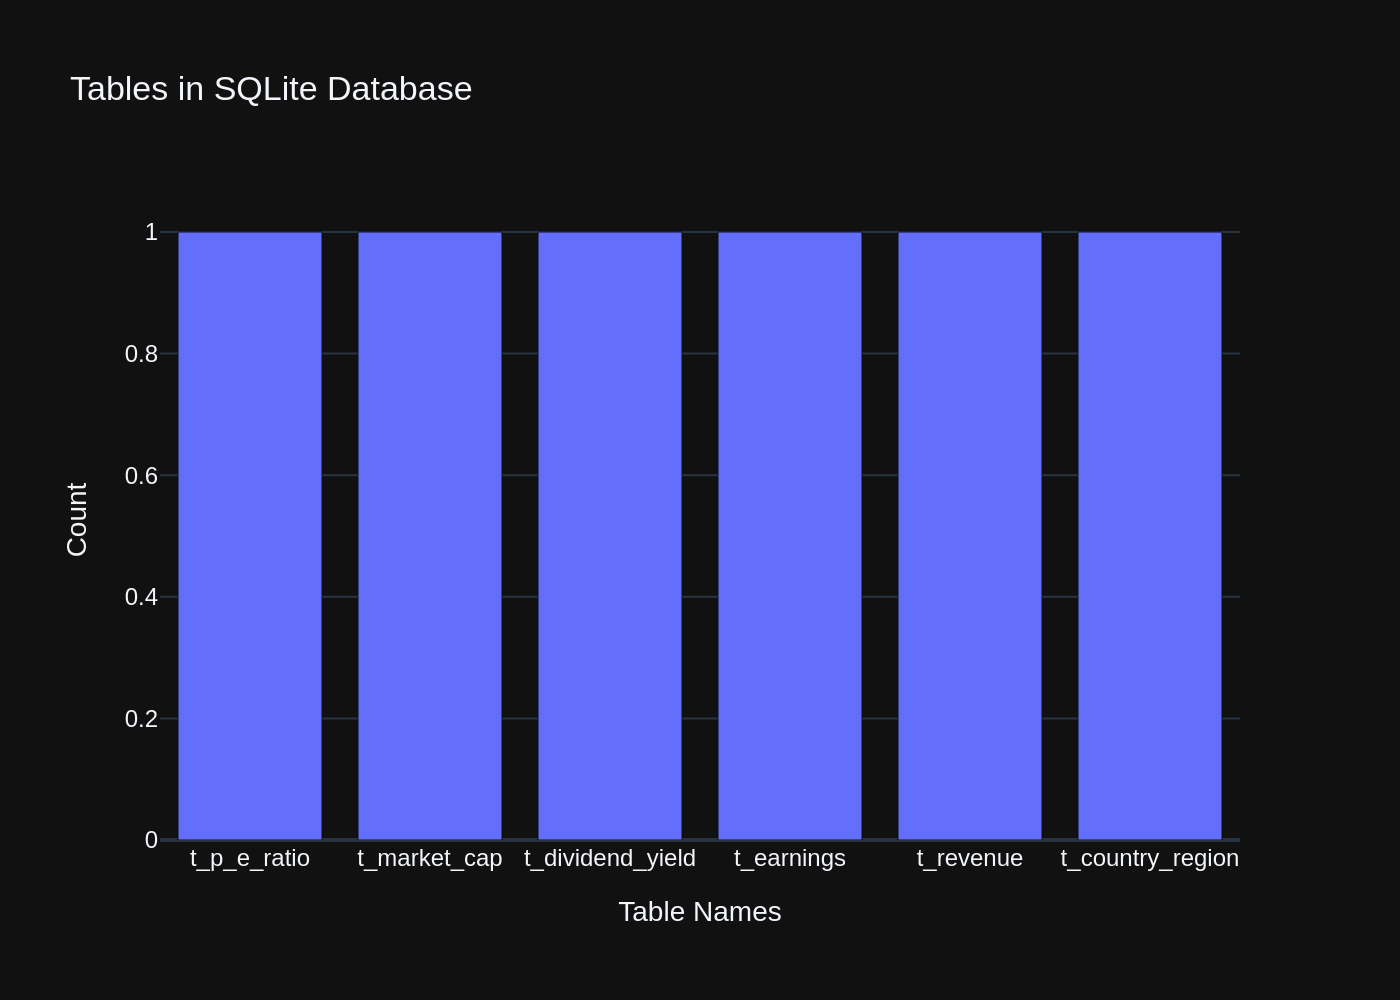

Number of requested results 10 is greater than number of elements in index 1, updating n_results = 1
Number of requested results 10 is greater than number of elements in index 6, updating n_results = 6
Number of requested results 10 is greater than number of elements in index 8, updating n_results = 8




# QUESTION - 3:  which table stores Company P/E Ratio, Hint: No need to generate SQL


Ollama parameters:
model=deepseek-coder-v2:latest,
options={},
keep_alive=None


Number of requested results 10 is greater than number of elements in index 1, updating n_results = 1
Number of requested results 10 is greater than number of elements in index 6, updating n_results = 6
Number of requested results 10 is greater than number of elements in index 8, updating n_results = 8



[( RETRY )]
***** 1 *****

Ollama parameters:
model=deepseek-coder-v2:latest,
options={},
keep_alive=None

[( <SQL> )]
generated SQL statement


SELECT * FROM t_p_e_ratio LIMIT 10


[( <DataFrame> )]
queried dataframe


,rank,name,symbol,pe_ratio_ttm,price_gbp,country
0,1,Imperial Petroleum,IMPP,0.109943,3.108797,Greece
1,2,Vertex Energy,VTNR,0.188889,0.092197,United States
2,3,Spin Master,TOY.TO,0.224758,17.414443,Canada
3,4,Performance Shipping,PSHG,0.225293,1.467916,Greece
4,5,TherapeuticsMD,TXMD,0.340956,1.280093,United States
5,6,Chimerix,CMRX,0.433204,0.684926,United States
6,7,Tingo Group,TIO,0.456954,0.525752,United States
7,8,Canacol Energy,CNE.TO,0.462276,2.005471,Canada
8,9,CR Energy,CRZK.DE,0.517095,5.083111,Germany
9,10,Vital Energy,VTLE,0.532125,20.336712,United States



Ollama parameters:
model=deepseek-coder-v2:latest,
options={},
keep_alive=None

[( <Python> )]
generated Plotly code


import plotly.graph_objects as go

if df.shape[0] == 1:
    fig = go.Figure(data=[go.Indicator(
        mode="number",
        value=df['pe_ratio_ttm'].values[0],
        number={'prefix': "P/E Ratio: ", 'suffix': ""}
    )])
else:
    fig = go.Figure()
    for i in range(df.shape[0]):
        fig.add_trace(go.Scatter(x=[i], y=[df['pe_ratio_ttm'].values[i]], mode='markers', name=f"{df['name'].values[i]} ({df['symbol'].values[i]})"))

fig.update_layout(title="Company P/E Ratios", xaxis_title="Rank", yaxis_title="P/E Ratio TTM")

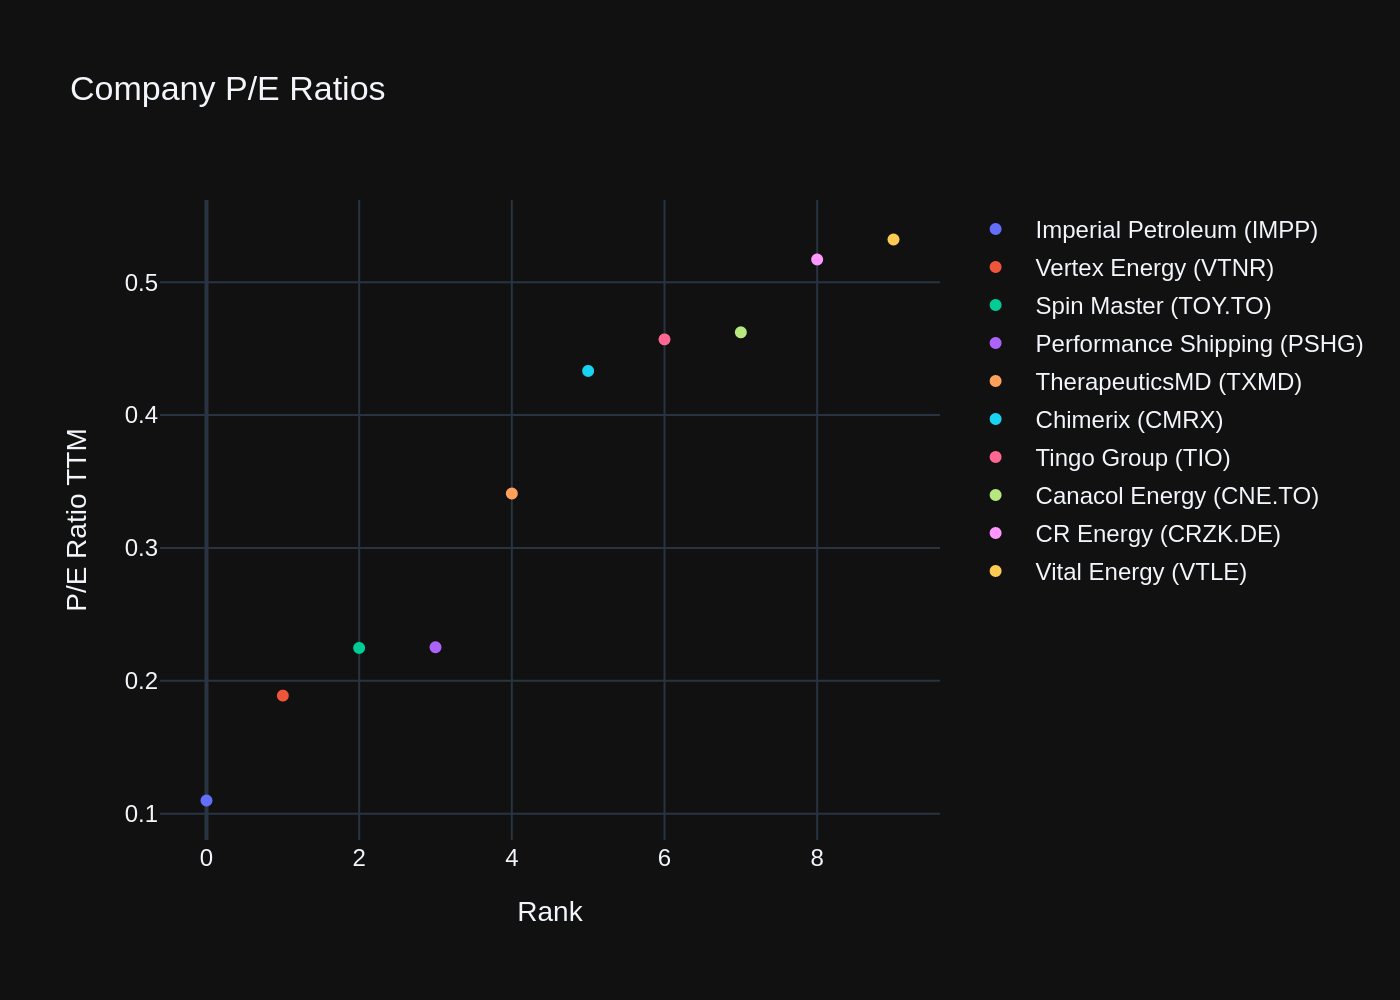

Number of requested results 10 is greater than number of elements in index 2, updating n_results = 2
Number of requested results 10 is greater than number of elements in index 6, updating n_results = 6
Number of requested results 10 is greater than number of elements in index 8, updating n_results = 8




# QUESTION - 4:  which table stores Company Dividend Yield, Hint: No need to generate SQL


Ollama parameters:
model=deepseek-coder-v2:latest,
options={},
keep_alive=None


Number of requested results 10 is greater than number of elements in index 2, updating n_results = 2
Number of requested results 10 is greater than number of elements in index 6, updating n_results = 6
Number of requested results 10 is greater than number of elements in index 8, updating n_results = 8



[( RETRY )]
***** 1 *****

Ollama parameters:
model=deepseek-coder-v2:latest,
options={},
keep_alive=None

[( <SQL> )]
generated SQL statement


SELECT name FROM sqlite_master WHERE type='table' AND name LIKE '%dividend_yield%' LIMIT 100


[( <DataFrame> )]
queried dataframe


,name
0,t_dividend_yield



Ollama parameters:
model=deepseek-coder-v2:latest,
options={},
keep_alive=None

[( <Python> )]
generated Plotly code


import plotly.graph_objects as go

if df.shape[0] == 1:
    fig = go.Figure(go.Indicator(
        mode="number",
        value=df['name'].iloc[0],
        title={"text": "Company Dividend Yield"}
    ))
else:
    fig = px.bar(df, x='name', y=[0]*len(df), labels={'x':'Company Name', 'y':'Dividend Yield'}, title='Company Dividend Yields')

fig.update_layout(height=400, width=600)

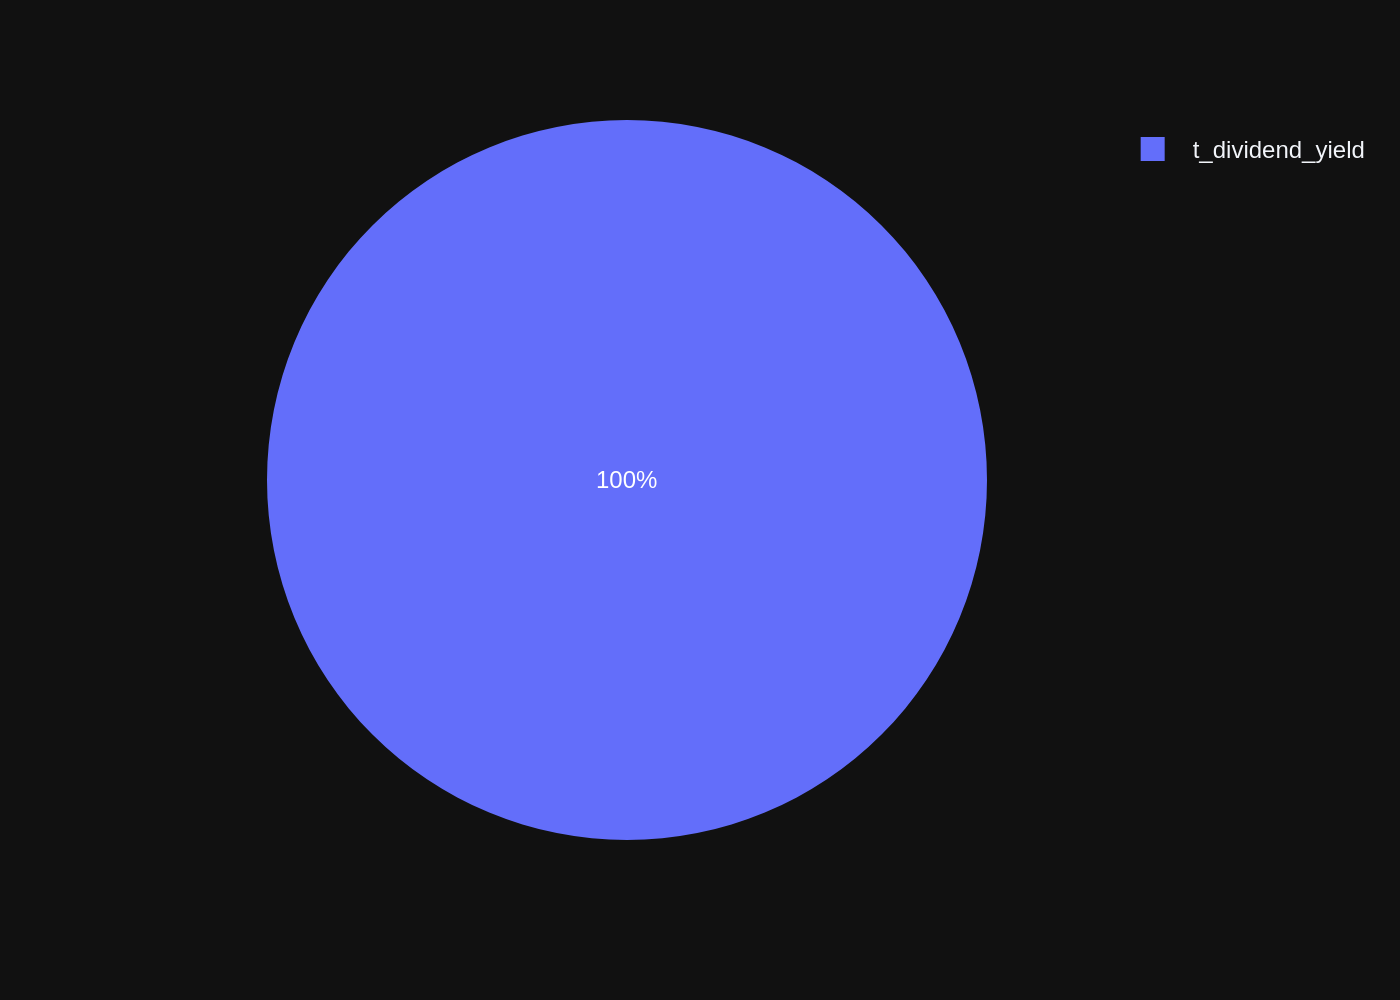

Number of requested results 10 is greater than number of elements in index 3, updating n_results = 3
Number of requested results 10 is greater than number of elements in index 6, updating n_results = 6
Number of requested results 10 is greater than number of elements in index 8, updating n_results = 8




# QUESTION - 5:  which table stores Company Market Cap, Hint: No need to generate SQL


Ollama parameters:
model=deepseek-coder-v2:latest,
options={},
keep_alive=None


Number of requested results 10 is greater than number of elements in index 3, updating n_results = 3
Number of requested results 10 is greater than number of elements in index 6, updating n_results = 6
Number of requested results 10 is greater than number of elements in index 8, updating n_results = 8



[( RETRY )]
***** 1 *****

Ollama parameters:
model=deepseek-coder-v2:latest,
options={},
keep_alive=None

[( <SQL> )]
generated SQL statement


SELECT name FROM sqlite_master WHERE type='table'


[( <DataFrame> )]
queried dataframe


,name
0,t_p_e_ratio
1,t_market_cap
2,t_dividend_yield
3,t_earnings
4,t_revenue
5,t_country_region



Ollama parameters:
model=deepseek-coder-v2:latest,
options={},
keep_alive=None

[( <Python> )]
generated Plotly code


import plotly.graph_objects as go
import pandas as pd

# Assuming df is your DataFrame
if len(df) == 1:
    fig = go.Figure(go.Indicator(
        mode="number",
        value=df['name'].iloc[0],
        title={"text": "Company Market Cap"}
    ))
else:
    fig = go.Figure(data=[go.Table(header=dict(values=['Name']), cells=dict(values=[[val for val in df['name']]]))])

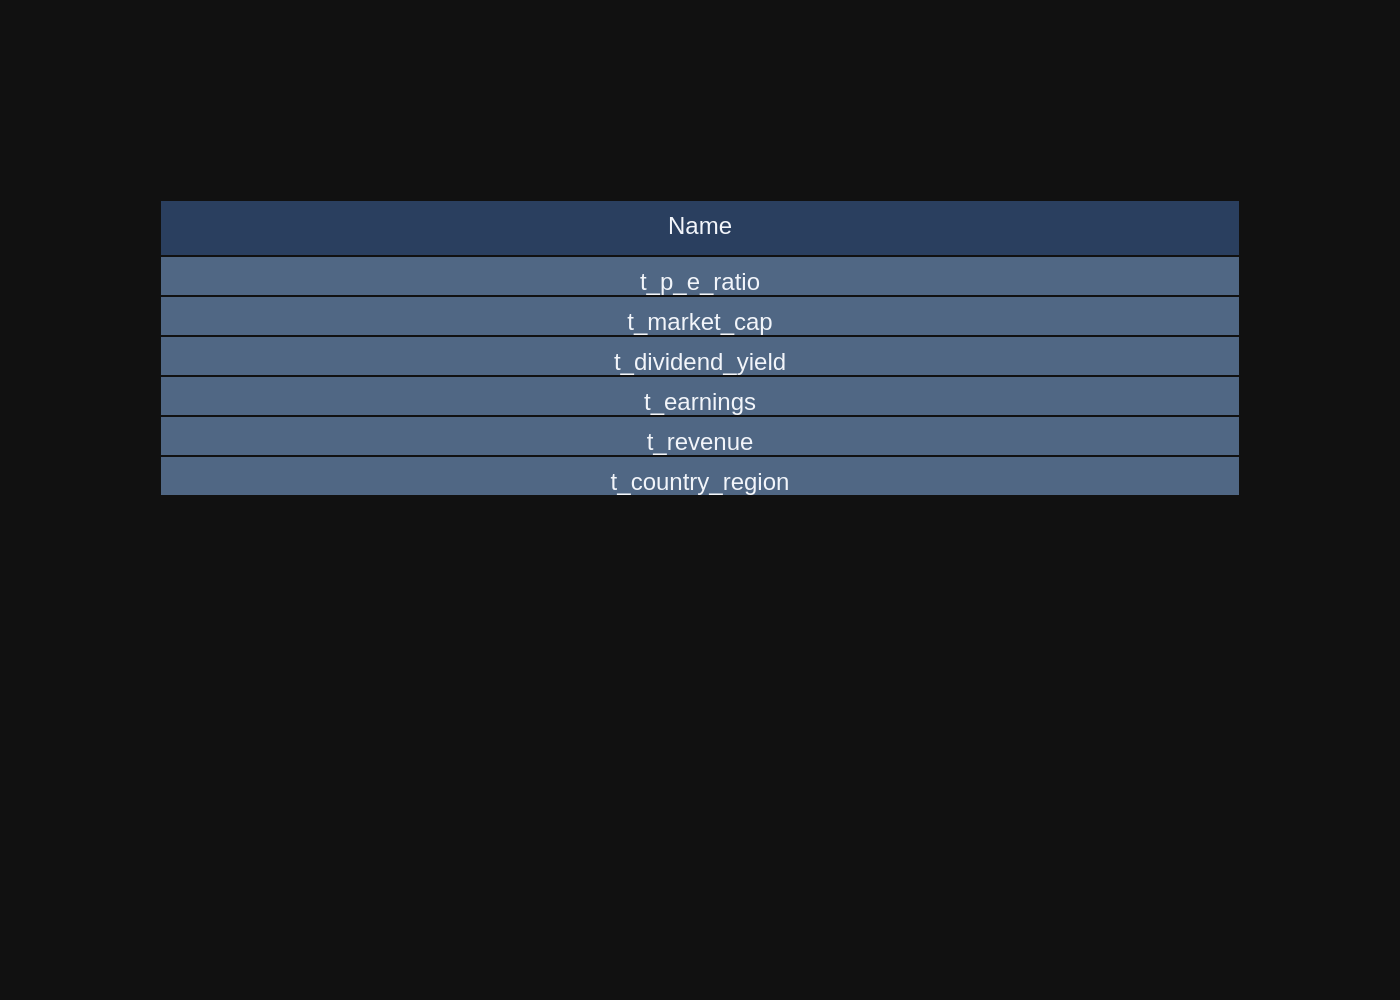

Number of requested results 10 is greater than number of elements in index 4, updating n_results = 4
Number of requested results 10 is greater than number of elements in index 6, updating n_results = 6
Number of requested results 10 is greater than number of elements in index 8, updating n_results = 8




# QUESTION - 6:  which table stores Company Revenue, Hint: No need to generate SQL


Ollama parameters:
model=deepseek-coder-v2:latest,
options={},
keep_alive=None


Number of requested results 10 is greater than number of elements in index 4, updating n_results = 4
Number of requested results 10 is greater than number of elements in index 6, updating n_results = 6
Number of requested results 10 is greater than number of elements in index 8, updating n_results = 8



[( RETRY )]
***** 1 *****

Ollama parameters:
model=deepseek-coder-v2:latest,
options={},
keep_alive=None

[( <SQL> )]
generated SQL statement


SELECT name FROM t_revenue LIMIT 100


[( <DataFrame> )]
queried dataframe


,name
0,Walmart
1,Amazon
2,Saudi Aramco
3,Sinopec
4,PetroChina
...,...
95,Archer Daniels Midland (ADM)
96,DHL Group (Deutsche Post)
97,FedEx
98,E.ON



Ollama parameters:
model=deepseek-coder-v2:latest,
options={},
keep_alive=None

[( <Python> )]
generated Plotly code


import plotly.graph_objects as go
import pandas as pd

# Assuming df is your DataFrame
if len(df) == 1:
    fig = go.Figure(go.Indicator(mode="number", value=df['name'].iloc[0], title={"text": "Company Revenue"}))
else:
    fig = go.Figure(data=[go.Table(header=dict(values=list(df.columns)), cells=dict(values=[df[col] for col in df.columns]))])

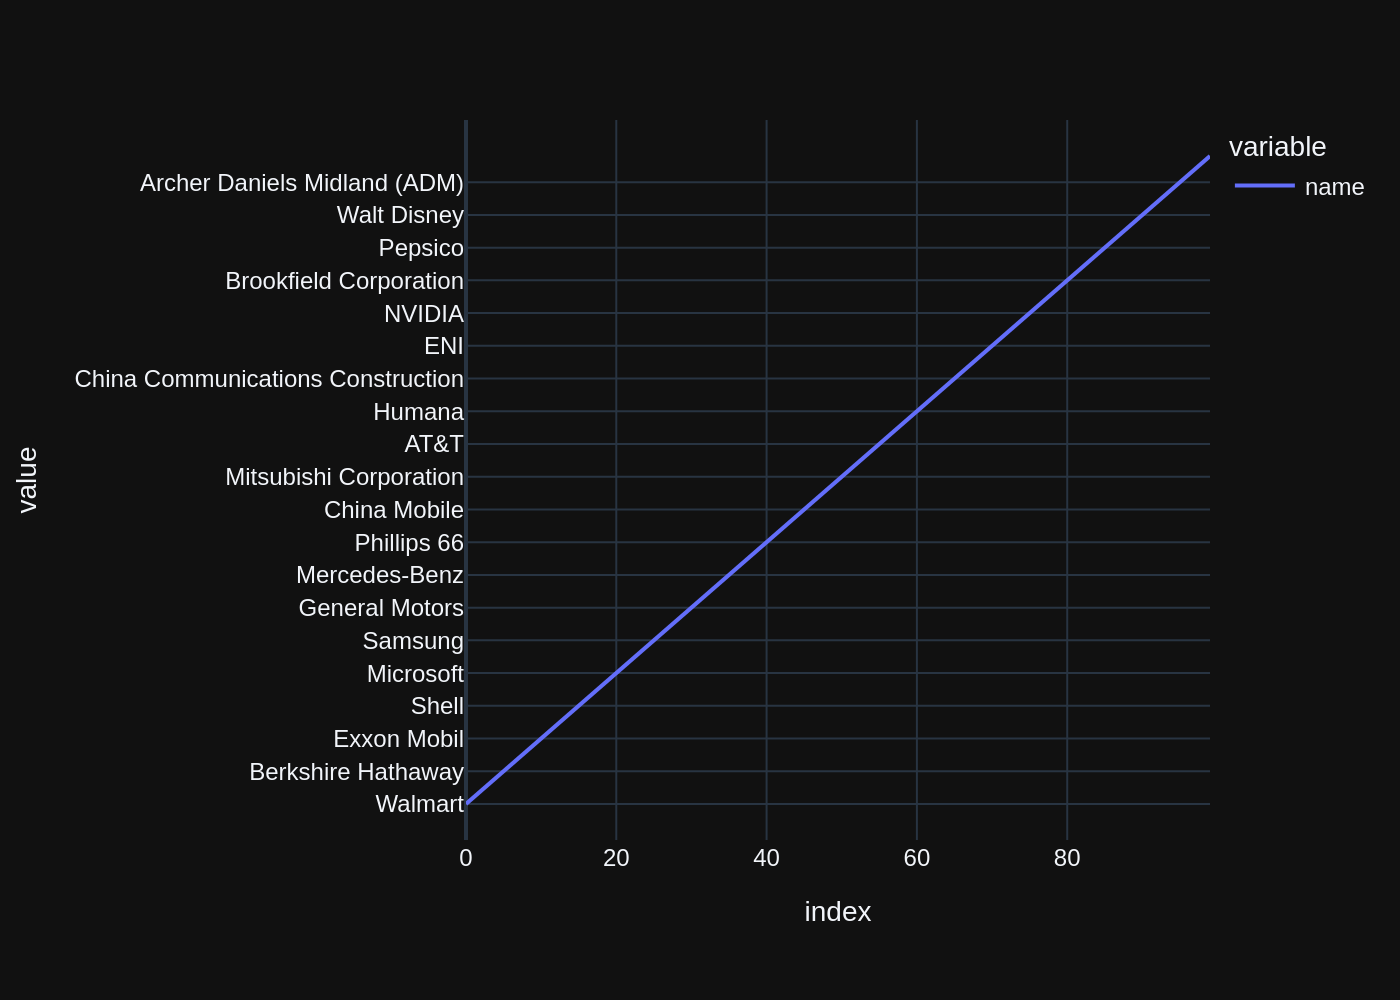

Number of requested results 10 is greater than number of elements in index 5, updating n_results = 5
Number of requested results 10 is greater than number of elements in index 6, updating n_results = 6
Number of requested results 10 is greater than number of elements in index 8, updating n_results = 8




# QUESTION - 7:  which table stores Company Earnings


Ollama parameters:
model=deepseek-coder-v2:latest,
options={},
keep_alive=None


Number of requested results 10 is greater than number of elements in index 5, updating n_results = 5
Number of requested results 10 is greater than number of elements in index 6, updating n_results = 6
Number of requested results 10 is greater than number of elements in index 8, updating n_results = 8



[( RETRY )]
***** 1 *****

Ollama parameters:
model=deepseek-coder-v2:latest,
options={},
keep_alive=None

[( <SQL> )]
generated SQL statement


SELECT name FROM t_earnings LIMIT 100


[( <DataFrame> )]
queried dataframe


,name
0,Saudi Aramco
1,Apple
2,Microsoft
3,Alphabet (Google)
4,Berkshire Hathaway
...,...
95,CVS Health
96,Intesa Sanpaolo
97,Reliance Industries
98,Charter Communications



Ollama parameters:
model=deepseek-coder-v2:latest,
options={},
keep_alive=None

[( <Python> )]
generated Plotly code


import plotly.graph_objects as go

fig = go.Figure()

if df.shape[0] == 1 and df.shape[1] == 1:
    fig.add_trace(go.Indicator(
        value=df.iloc[0, 0],
        title={"text": "Unique Value"},
        mode="number"
    ))
else:
    fig.add_bar(x=df['name'], y=[1]*len(df), text=df['name'], marker_color='rgba(55, 128, 191, 0.7)')

fig.update_layout(title="Company Names", xaxis_title="Name", yaxis_title="Count")

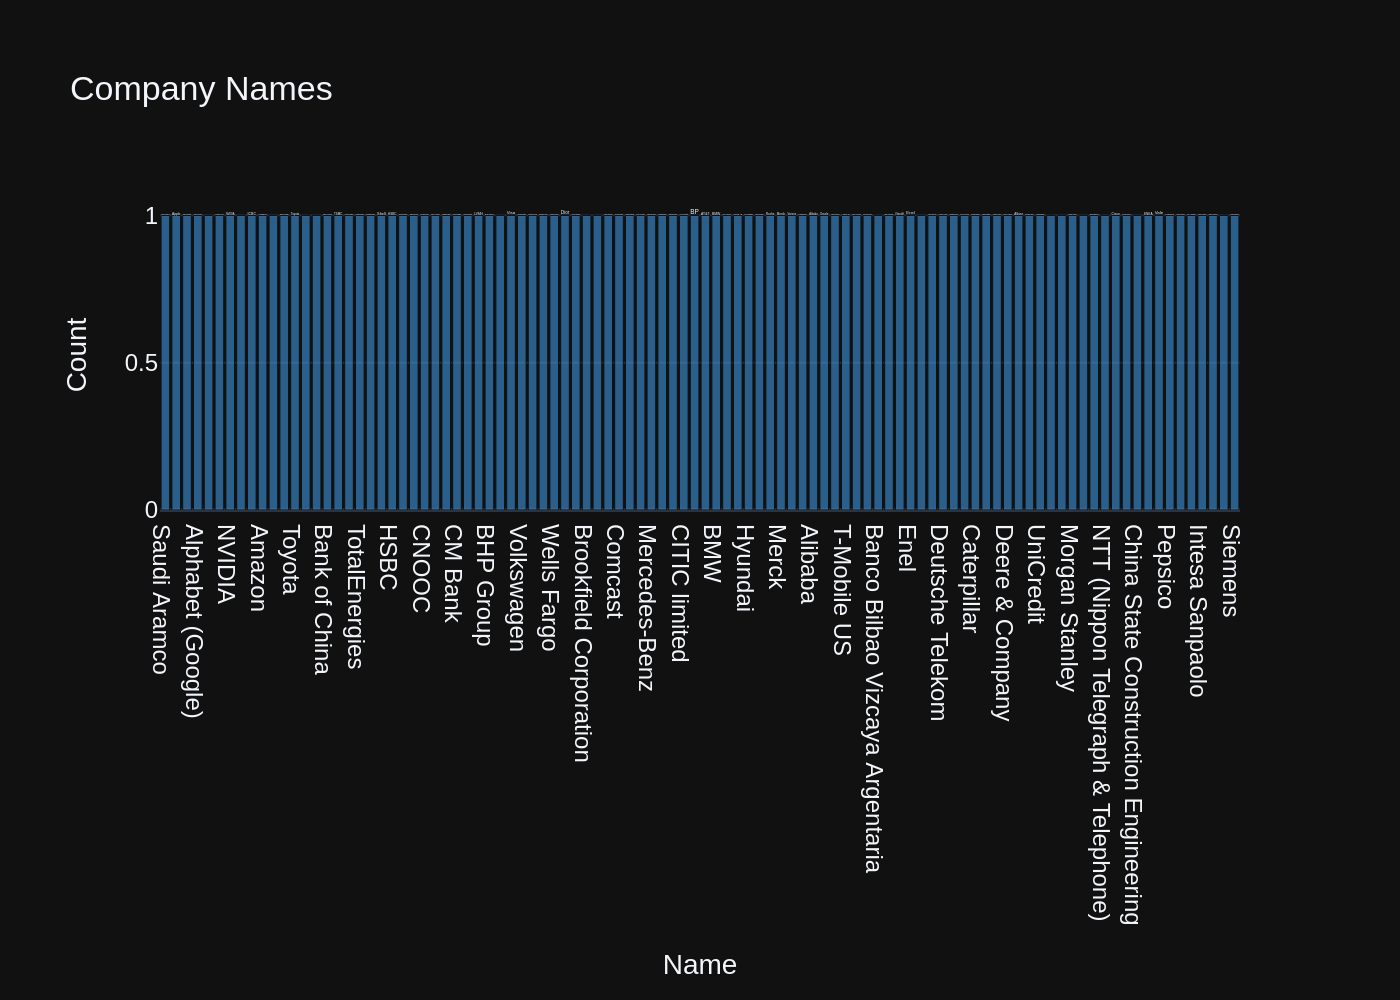

Number of requested results 10 is greater than number of elements in index 6, updating n_results = 6
Number of requested results 10 is greater than number of elements in index 6, updating n_results = 6
Number of requested results 10 is greater than number of elements in index 8, updating n_results = 8




# QUESTION - 8:  Find 10 companyies with the lowest PE Ratio above 10 in Germany


Ollama parameters:
model=deepseek-coder-v2:latest,
options={},
keep_alive=None

[( <SQL> )]
generated SQL statement


SELECT name 
FROM t_p_e_ratio 
WHERE country = 'Germany' AND pe_ratio_ttm > 10 
ORDER BY pe_ratio_ttm ASC 
LIMIT 10


[( <DataFrame> )]
queried dataframe


,name
0,FORTEC Elektronik AG
1,New Work
2,Fuchs Petrolub
3,Uzin Utz
4,Bastei Lübbe
5,JOST Werke SE
6,Einhell Germany
7,Allgeier
8,ALBA SE
9,MLP SE



Ollama parameters:
model=deepseek-coder-v2:latest,
options={},
keep_alive=None

[( <Python> )]
generated Plotly code


import plotly.graph_objects as go
import numpy as np

if df.shape[0] == 1:
    fig = go.Figure(go.Indicator(
        mode="number",
        value=df['pe_ratio_ttm'].values[0],
        number={'prefix': "PE Ratio:"}
    ))
else:
    fig = go.Figure()
    fig.add_trace(go.Bar(x=df['name'], y=df['pe_ratio_ttm']))

fig.update_layout(title='10 Companies with the Lowest PE Ratio Above 10 in Germany',
                  xaxis_title='Company Name',
                  yaxis_title='PE Ratio TTM')

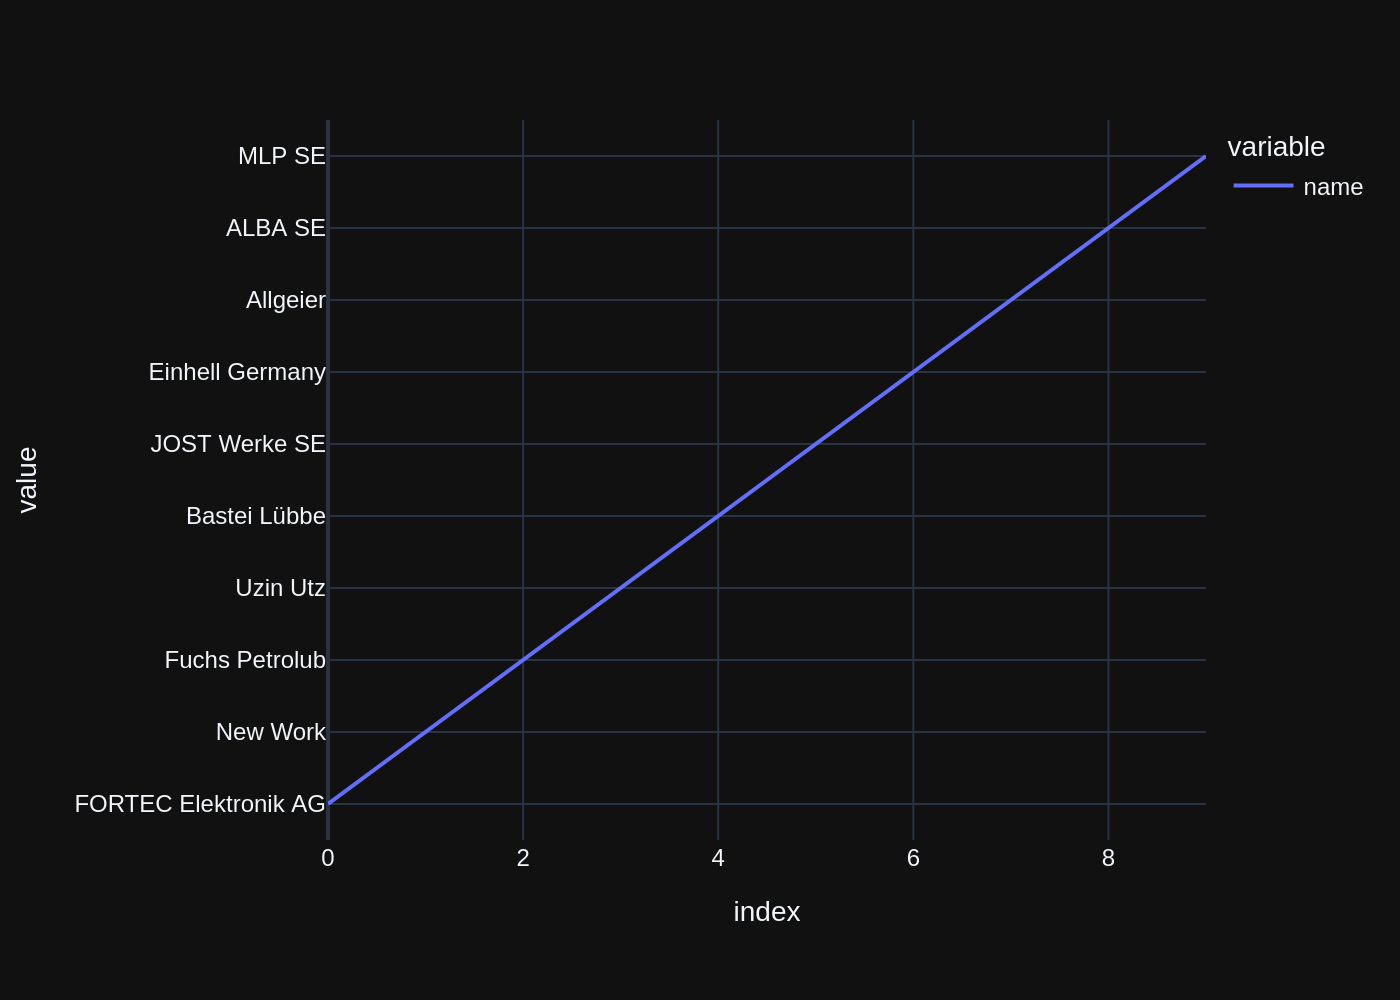

Number of requested results 10 is greater than number of elements in index 7, updating n_results = 7
Number of requested results 10 is greater than number of elements in index 6, updating n_results = 6
Number of requested results 10 is greater than number of elements in index 8, updating n_results = 8




# QUESTION - 9:  Find top 10 companyies in the United States with the heighest market cap


Ollama parameters:
model=deepseek-coder-v2:latest,
options={},
keep_alive=None

Ollama parameters:
model=deepseek-coder-v2:latest,
options={},
keep_alive=None

[( <SQL> )]
generated SQL statement


SELECT DISTINCT country FROM t_market_cap WHERE country LIKE '%United States%'

Most relevant table used for this query: `t_market_cap`

Number of requested results 10 is greater than number of elements in index 7, updating n_results = 7
Number of requested results 10 is greater than number of elements in index 6, updating n_results = 6
Number of requested results 10 is greater than number of elements in index 8, updating n_results = 8



[( RETRY )]
***** 1 *****

Ollama parameters:
model=deepseek-coder-v2:latest,
options={},
keep_alive=None

[( <SQL> )]
generated SQL statement


SELECT name, marketcap FROM t_market_cap WHERE country LIKE '%United States%' ORDER BY marketcap DESC LIMIT 10


[( <DataFrame> )]
queried dataframe


,name,marketcap
0,Apple,2.689903e+12
1,Microsoft,2.427170e+12
2,NVIDIA,2.259353e+12
3,Alphabet (Google),1.549815e+12
4,Amazon,1.506038e+12
5,Meta Platforms (Facebook),1.095756e+12
6,Berkshire Hathaway,7.492296e+11
7,Tesla,6.399479e+11
8,Broadcom,6.096217e+11
9,Eli Lilly,5.996346e+11



Ollama parameters:
model=deepseek-coder-v2:latest,
options={},
keep_alive=None

[( <Python> )]
generated Plotly code


import plotly.graph_objects as go
import numpy as np

if len(df) == 1:
    fig = go.Figure(go.Indicator(
        mode="number",
        value=df['marketcap'].values[0],
        title={"text": f"{df['name'].values[0]} Market Cap"},
        domain={'x': [0, 1], 'y': [0, 1]}
    ))
else:
    fig = go.Figure(data=[go.Bar(x=df['name'], y=df['marketcap'])])

fig.update_layout(title='Top 10 Companies by Market Cap in the United States')

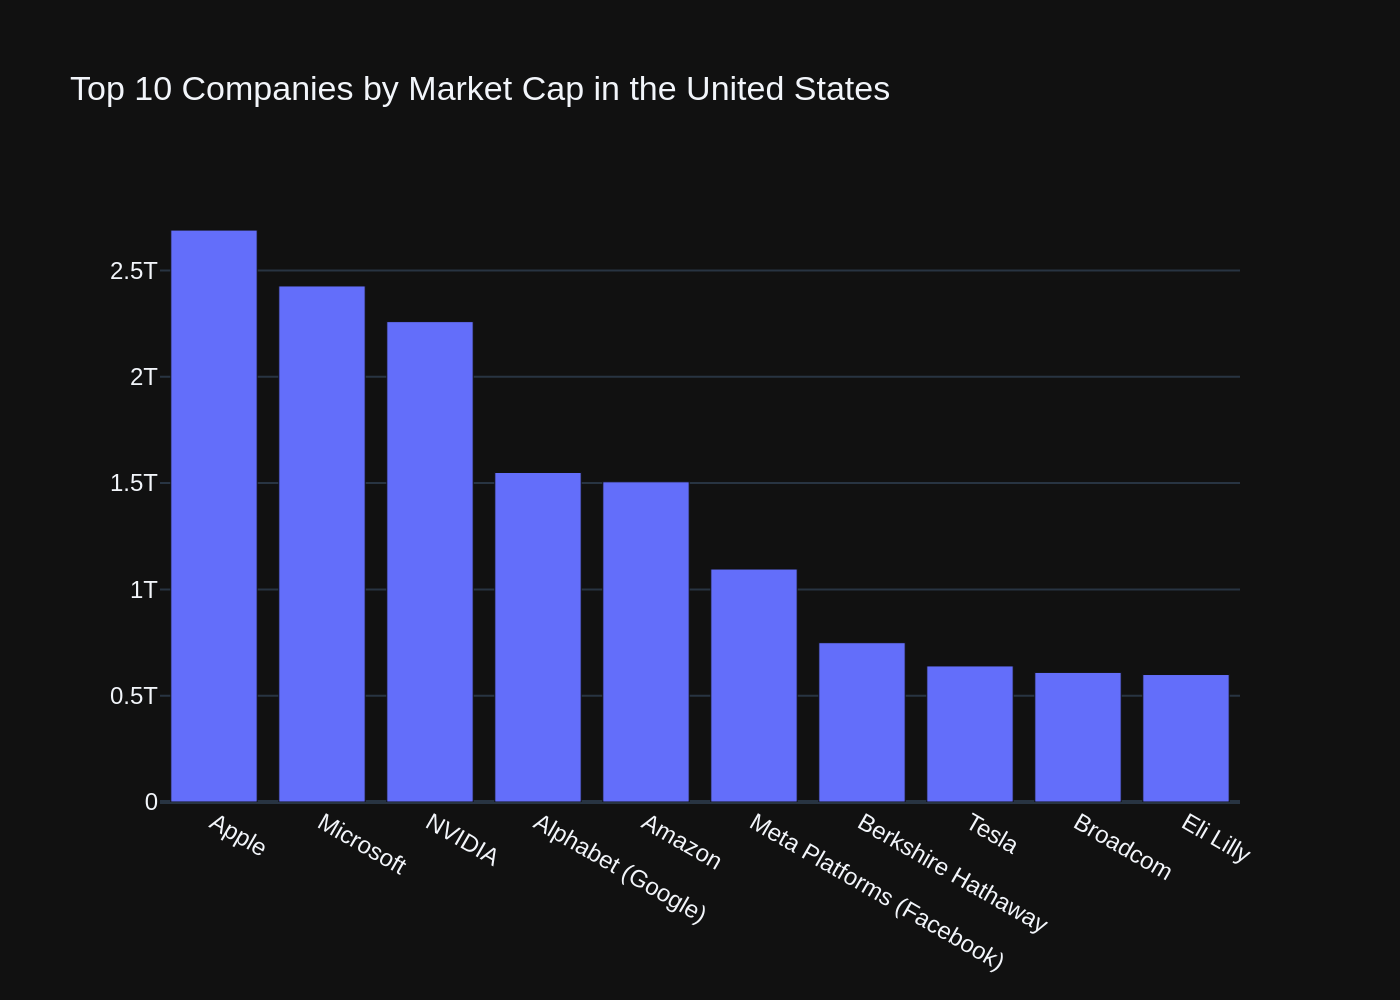

Number of requested results 10 is greater than number of elements in index 8, updating n_results = 8
Number of requested results 10 is greater than number of elements in index 6, updating n_results = 6
Number of requested results 10 is greater than number of elements in index 8, updating n_results = 8




# QUESTION - 10:  Find the customer with the most invoices 


Ollama parameters:
model=deepseek-coder-v2:latest,
options={},
keep_alive=None

[( <SQL> )]
generated SQL statement


SELECT c.customer_id, c.first_name, c.last_name, COUNT(i.invoice_id) AS total_invoices
FROM customers c
JOIN invoices i ON c.customer_id = i.customer_id
GROUP BY c.customer_id
ORDER BY total_invoices DESC
LIMIT 1

Number of requested results 10 is greater than number of elements in index 8, updating n_results = 8
Number of requested results 10 is greater than number of elements in index 6, updating n_results = 6
Number of requested results 10 is greater than number of elements in index 8, updating n_results = 8



[( RETRY )]
***** 1 *****

Ollama parameters:
model=deepseek-coder-v2:latest,
options={},
keep_alive=None

[( <SQL> )]
generated SQL statement


SELECT c.customer_id, c.first_name, c.last_name, COUNT(i.invoice_id) AS total_invoices
FROM customers c
JOIN invoices i ON c.customer_id = i.customer_id
GROUP BY c.customer_id
ORDER BY total_invoices DESC
LIMIT 1

Number of requested results 10 is greater than number of elements in index 8, updating n_results = 8
Number of requested results 10 is greater than number of elements in index 6, updating n_results = 6
Number of requested results 10 is greater than number of elements in index 8, updating n_results = 8



[( RETRY )]
***** 2 *****

Ollama parameters:
model=deepseek-coder-v2:latest,
options={},
keep_alive=None
[ERROR-SQL] Failed to generate SQL for prompt: 
                For this question: 
                For this question: Find the customer with the most invoices , 
                your generated SQL statement: SELECT c.customer_id, c.first_name, c.last_name, COUNT(i.invoice_id) AS total_invoices
FROM customers c
JOIN invoices i ON c.customer_id = i.customer_id
GROUP BY c.customer_id
ORDER BY total_invoices DESC
LIMIT 1 results in the following exception: [ERROR-DB] Failed to execute SQL: SELECT c.customer_id, c.first_name, c.last_name, COUNT(i.invoice_id) AS total_invoices
FROM customers c
JOIN invoices i ON c.customer_id = i.customer_id
GROUP BY c.customer_id
ORDER BY total_invoices DESC
LIMIT 1
 Execution failed on sql 'SELECT c.customer_id, c.first_name, c.last_name, COUNT(i.invoice_id) AS total_invoices
FROM customers c
JOIN invoices i ON c.customer_id = i.customer_id
GROUP BY 

Number of requested results 10 is greater than number of elements in index 8, updating n_results = 8
Number of requested results 10 is greater than number of elements in index 6, updating n_results = 6
Number of requested results 10 is greater than number of elements in index 8, updating n_results = 8




# QUESTION - 11:  
Find top 5 companyies in Asia with the hightes PE Ratio above 40, list company name and PE ratio,
Hint: "Asia" is a region name, you need to join "t_p_e_ratio" table with "t_country_region" table 
on "country" columns to answer this question .



Ollama parameters:
model=deepseek-coder-v2:latest,
options={},
keep_alive=None

[( <SQL> )]
generated SQL statement


SELECT t_p_e_ratio.name, t_p_e_ratio.pe_ratio_ttm
FROM t_p_e_ratio
JOIN t_country_region ON t_p_e_ratio.country = t_country_region.country
WHERE t_country_region.region = 'Asia' AND t_p_e_ratio.pe_ratio_ttm > 40
ORDER BY t_p_e_ratio.pe_ratio_ttm DESC
LIMIT 5


[( <DataFrame> )]
queried dataframe


,name,pe_ratio_ttm
0,Ceragon Networks,1.573740e+18
1,National Industries Group Holding,3.459630e+05
2,Gulf Investment House Company,2.369150e+05
3,Kuwait Cement Company,1.047660e+05
4,Kuwait Investment Company,6.837150e+04



Ollama parameters:
model=deepseek-coder-v2:latest,
options={},
keep_alive=None

[( <Python> )]
generated Plotly code


import plotly.graph_objects as go

fig = go.Figure()

if df['pe_ratio_ttm'].nunique() == 1:
    fig.add_trace(go.Indicator(
        mode="number",
        value=df['pe_ratio_ttm'].iloc[0],
        title={"text": "PE Ratio"},
        domain={'x': [0, 1], 'y': [0, 1]}
    ))
else:
    fig.add_trace(go.Bar(
        x=df['name'],
        y=df['pe_ratio_ttm'],
        marker_color='rgba(55, 128, 191, 0.7)'
    ))

fig.update_layout(
    title="Top 5 Companies in Asia with Highest PE Ratio above 40",
    xaxis_title="Company Name",
    yaxis_title="PE Ratio"
)

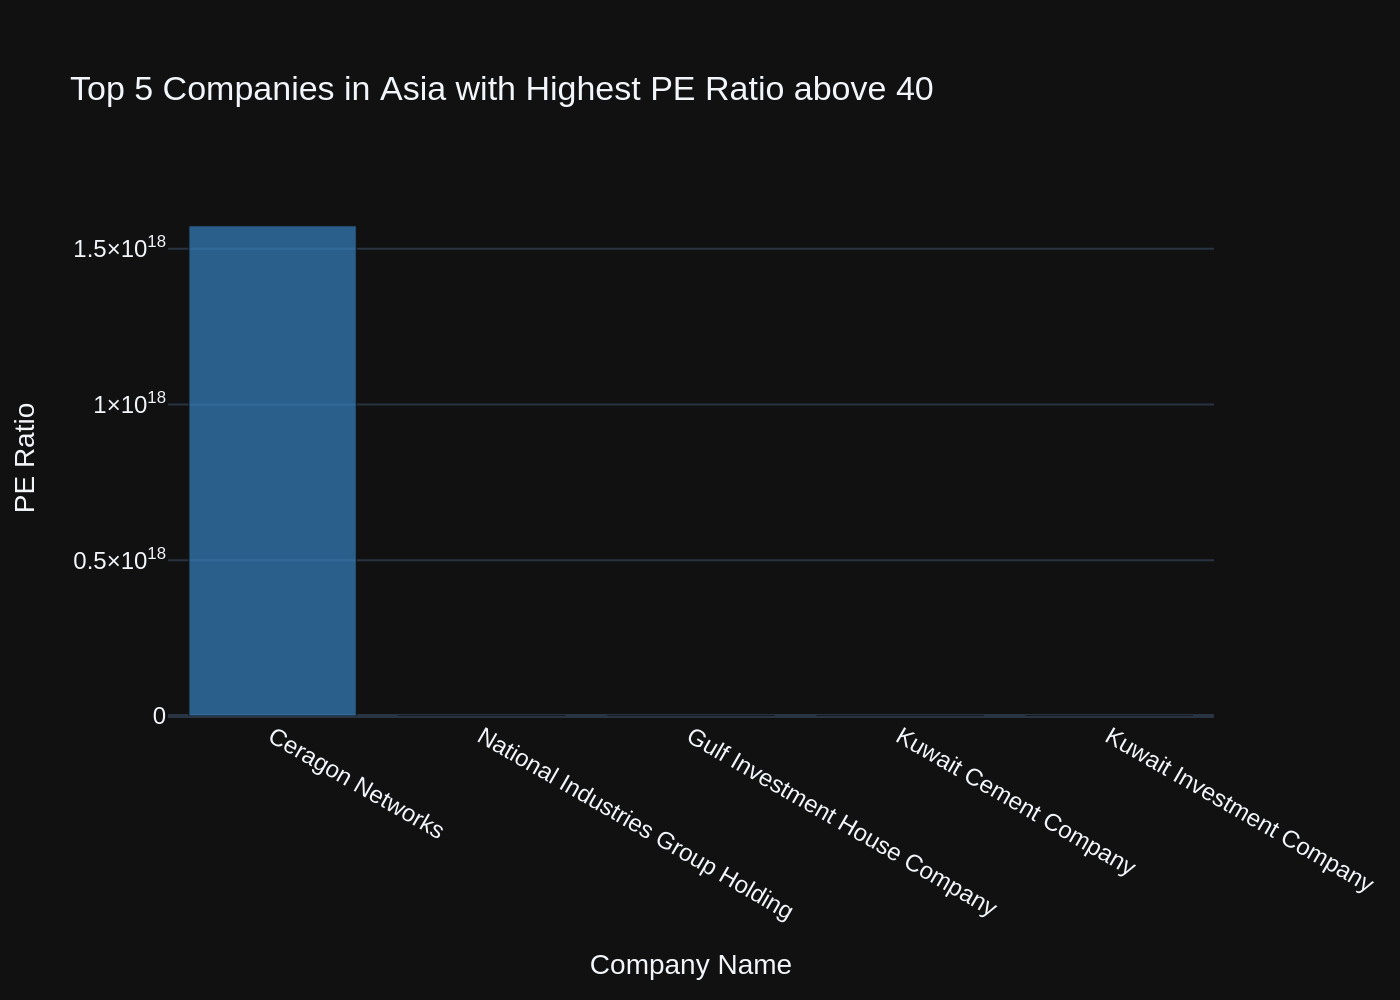

Number of requested results 10 is greater than number of elements in index 9, updating n_results = 9
Number of requested results 10 is greater than number of elements in index 6, updating n_results = 6
Number of requested results 10 is greater than number of elements in index 8, updating n_results = 8




# QUESTION - 12:  
Find top 5 companyies with the lowest PE Ratio in the range of 20-30, list their names and respective PE ratios,



Ollama parameters:
model=deepseek-coder-v2:latest,
options={},
keep_alive=None

[( <SQL> )]
generated SQL statement


SELECT name, pe_ratio_ttm 
FROM t_p_e_ratio 
WHERE pe_ratio_ttm BETWEEN 20 AND 30 
ORDER BY pe_ratio_ttm ASC 
LIMIT 5


[( <DataFrame> )]
queried dataframe


,name,pe_ratio_ttm
0,Fresenius,20.0133
1,Equatorial Energia,20.0178
2,Viper Energy Partners,20.0268
3,Avanza Bank,20.0304
4,Select Energy Services,20.0370



Ollama parameters:
model=deepseek-coder-v2:latest,
options={},
keep_alive=None

[( <Python> )]
generated Plotly code


import plotly.graph_objects as go
import numpy as np

if df['pe_ratio_ttm'].nunique() == 1:
    fig = go.Figure(go.Indicator(
        mode="number",
        value=df['pe_ratio_ttm'].iloc[0],
        number={'prefix': "$"},
        title={"text": "PE Ratio"}
    ))
else:
    fig = go.Figure()
    fig.add_trace(go.Bar(x=df['name'], y=df['pe_ratio_ttm'], marker_color='rgba(55, 128, 191, 0.7)'))
    fig.update_layout(title="Top 5 Companies with the Lowest PE Ratio in Range 20-30",
                      xaxis_tickangle=-45,
                      xaxis=dict(categoryorder='total descending'),
                      yaxis=dict(title='PE Ratio'))

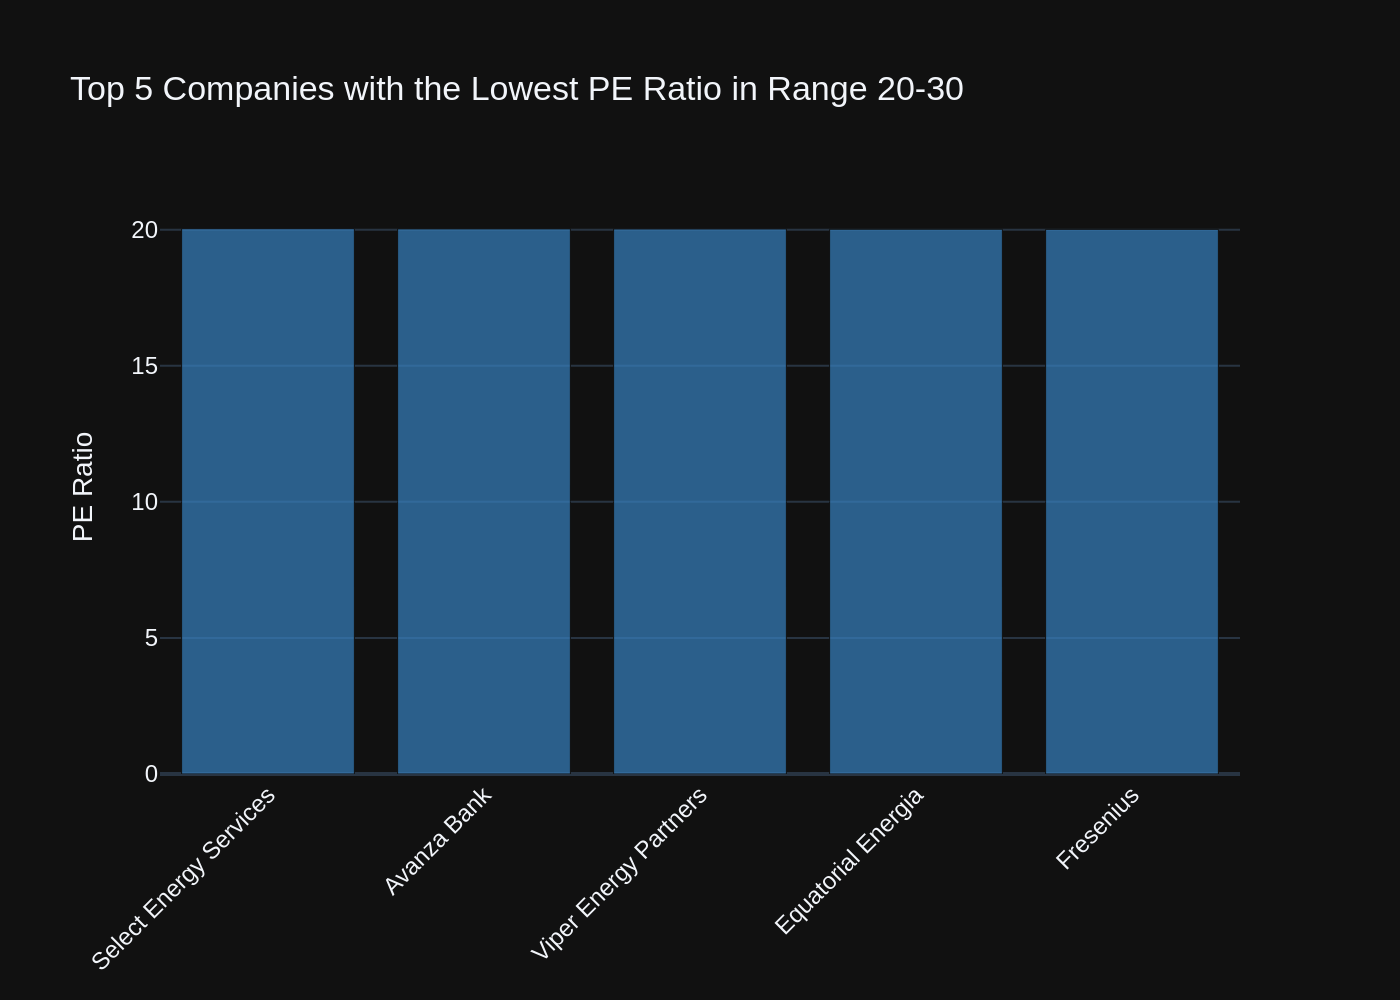

Number of requested results 10 is greater than number of elements in index 6, updating n_results = 6
Number of requested results 10 is greater than number of elements in index 8, updating n_results = 8




# QUESTION - 13:   
"What are the Top 20 companies in the United States ranked by Dividend Yield"



Ollama parameters:
model=deepseek-coder-v2:latest,
options={},
keep_alive=None

Ollama parameters:
model=deepseek-coder-v2:latest,
options={},
keep_alive=None

[( <SQL> )]
generated SQL statement


SELECT symbol, dividend_yield_ttm FROM t_dividend_yield WHERE country = 'United States' ORDER BY dividend_yield_ttm DESC LIMIT 20


[( <DataFrame> )]
queried dataframe


,symbol,dividend_yield_ttm
0,LIAN,300940.00
1,LMPX,106250.00
2,MBI,22346.40
3,MEDS,10540.20
4,MACK,9980.17
5,TRML,6047.20
6,LENZ,5998.34
7,RILY,5655.04
8,FF,4875.44
9,SAVE,3278.69



Ollama parameters:
model=deepseek-coder-v2:latest,
options={},
keep_alive=None

[( <Python> )]
generated Plotly code


import plotly.graph_objects as go

if df.shape[0] == 1:
    fig = go.Figure(go.Indicator(
        mode="number",
        value=df['dividend_yield_ttm'].values[0],
        title={"text": "Top Dividend Yield"},
        number={'prefix': "%"}
    ))
else:
    fig = go.Figure()
    fig.add_trace(go.Bar(x=df['symbol'], y=df['dividend_yield_ttm'], text=df['dividend_yield_ttm']))
    fig.update_layout(title="Top 20 Companies in the United States by Dividend Yield", xaxis_title="Company Symbol", yaxis_title="Dividend Yield (TTM)")

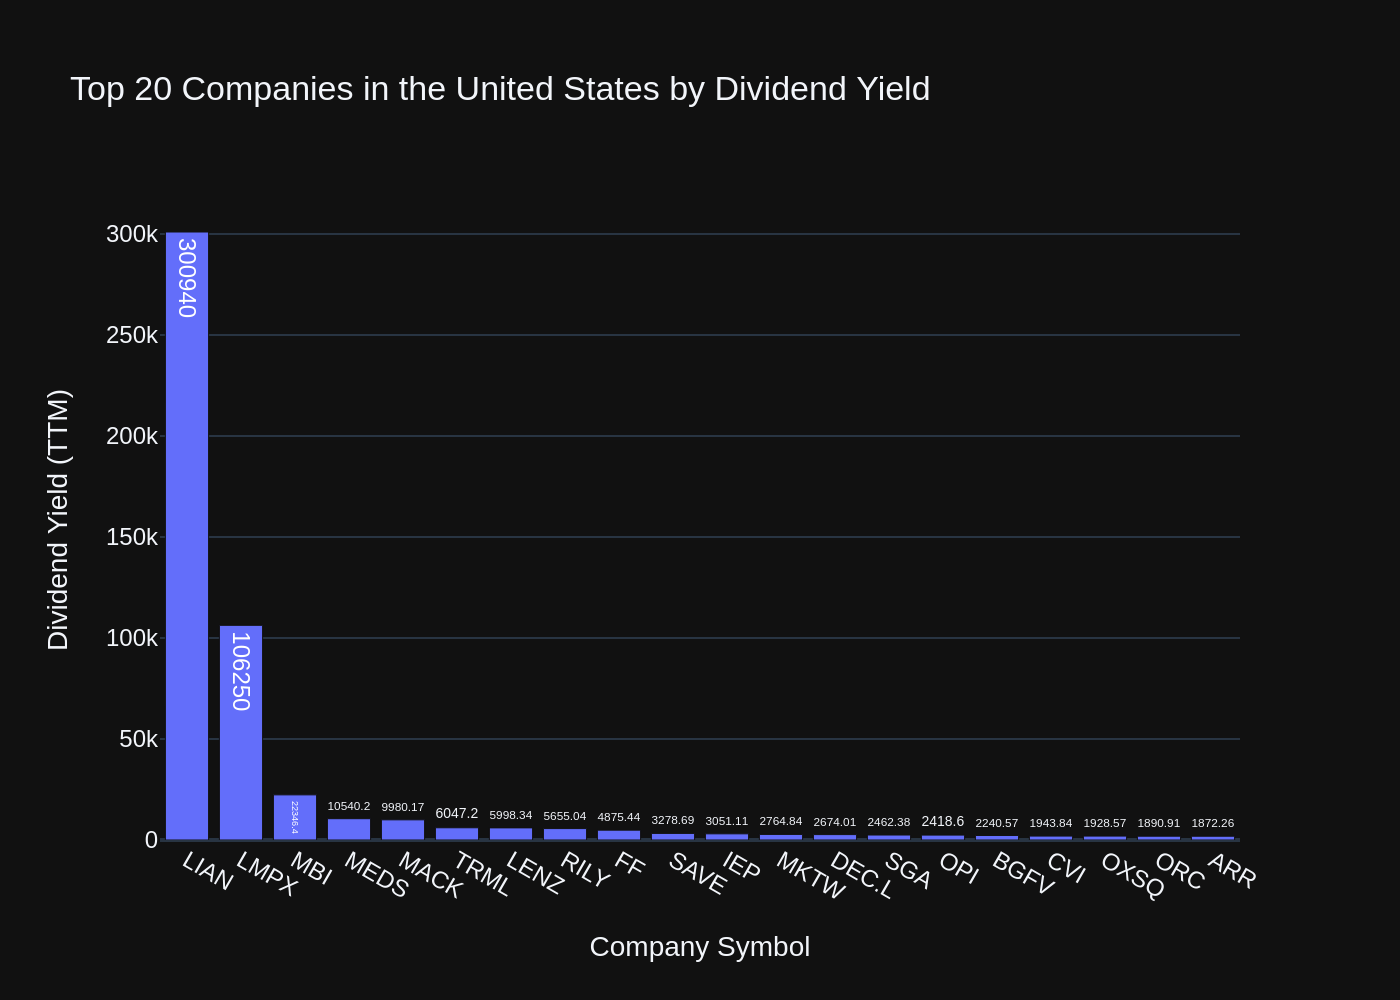

Number of requested results 10 is greater than number of elements in index 6, updating n_results = 6
Number of requested results 10 is greater than number of elements in index 8, updating n_results = 8




# QUESTION - 14:   
"What are the Top 20 companies in the United States ranked by Revenue"



Ollama parameters:
model=deepseek-coder-v2:latest,
options={},
keep_alive=None

Ollama parameters:
model=deepseek-coder-v2:latest,
options={},
keep_alive=None

[( <SQL> )]
generated SQL statement


SELECT name FROM t_revenue WHERE country = 'United States' ORDER BY revenue_ttm DESC LIMIT 20


[( <DataFrame> )]
queried dataframe


,name
0,Walmart
1,Amazon
2,Berkshire Hathaway
3,Apple
4,UnitedHealth
5,CVS Health
6,Exxon Mobil
7,Alphabet (Google)
8,McKesson
9,Cencora



Ollama parameters:
model=deepseek-coder-v2:latest,
options={},
keep_alive=None

[( <Python> )]
generated Plotly code


import plotly.graph_objects as go
import numpy as np

if df['name'].nunique() == 1:
    fig = go.Figure(go.Indicator(
        mode="number",
        value=df['name'],
        title={"text": "Top Company by Revenue"},
        number={'prefix': ''}
    ))
else:
    fig = go.Figure(data=[go.Bar(x=df['name'], y=df['revenue_ttm'])])
    fig.update_layout(title='Top 20 Companies in the United States by Revenue', xaxis_title='Company Name', yaxis_title='Revenue (TTM)')

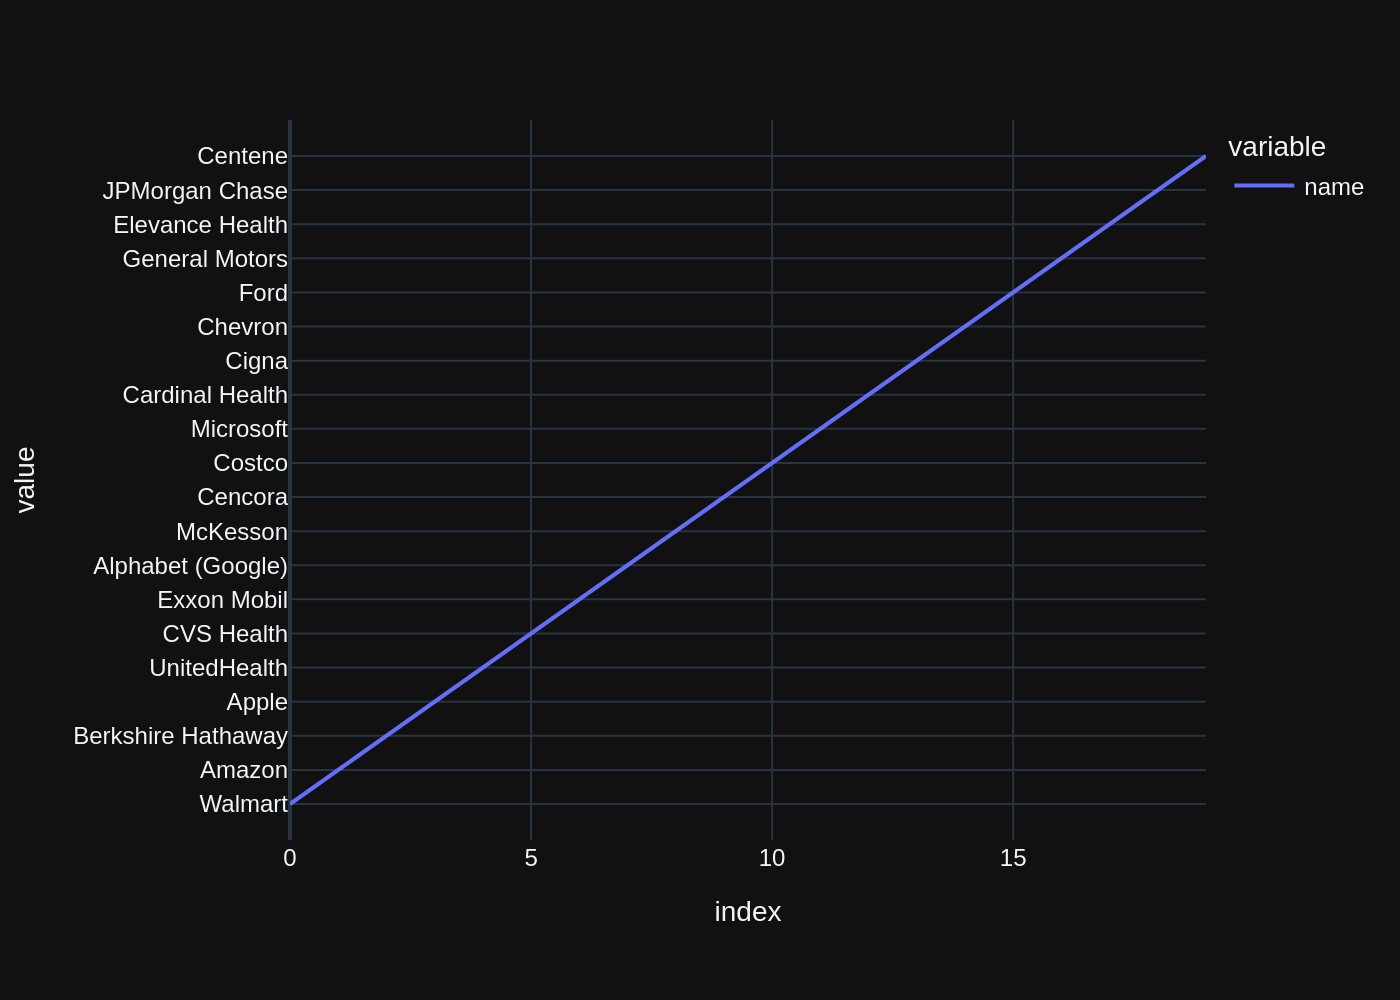

Number of requested results 10 is greater than number of elements in index 6, updating n_results = 6
Number of requested results 10 is greater than number of elements in index 8, updating n_results = 8




# QUESTION - 15:  
Find Top 10 Company by Dividend Yield in each country



Ollama parameters:
model=deepseek-coder-v2:latest,
options={},
keep_alive=None

[( <SQL> )]
generated SQL statement


SELECT t_dividend_yield.name
FROM t_dividend_yield
JOIN (
    SELECT DISTINCT country
    FROM t_dividend_yield
) AS countries ON t_dividend_yield.country = countries.country
ORDER BY t_dividend_yield.country, t_dividend_yield.dividend_yield_ttm DESC
LIMIT 10


[( <DataFrame> )]
queried dataframe


,name
0,Central Puerto
1,BBVA Argentina
2,Banco Macro
3,IRSA Inversiones y Representaciones
4,Galicia Financial Group
5,Grupo Supervielle
6,Ferrum S.A. de Cerámica y Metalurgia
7,Aluar Aluminio Argentino
8,YPF \n (Yacimientos Petrolíferos Fiscales)
9,MercadoLibre



Ollama parameters:
model=deepseek-coder-v2:latest,
options={},
keep_alive=None

[( <Python> )]
generated Plotly code


import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd

# Assuming df is your DataFrame
if len(df) == 1:
    fig = go.Figure(go.Indicator(
        mode="number",
        value=df['dividend_yield_ttm'].values[0],
        title={"text": f"{df['name'].values[0]}<br><span style='font-size:0.8em;color:grey'>Dividend Yield TTM</span>"},
        number={'prefix': " %"}
    ))
else:
    fig = make_subplots(rows=1, cols=len(df['country'].unique()), subplot_titles=[f"Top 10 Companies by Dividend Yield in {country}" for country in df['country'].unique()])
    
    for i, country in enumerate(df['country'].unique()):
        top_countries = df[df['country'] == country].head(10)
        fig.add_trace(go.Bar(x=top_countries['name'], y=top_countries['dividend_yield_ttm'], name=country), row=1, col=i+1)
    
    for i in range(len(df)):
        fig.update_traces(textposition='auto', texttemplate='%{y:.2f}%')

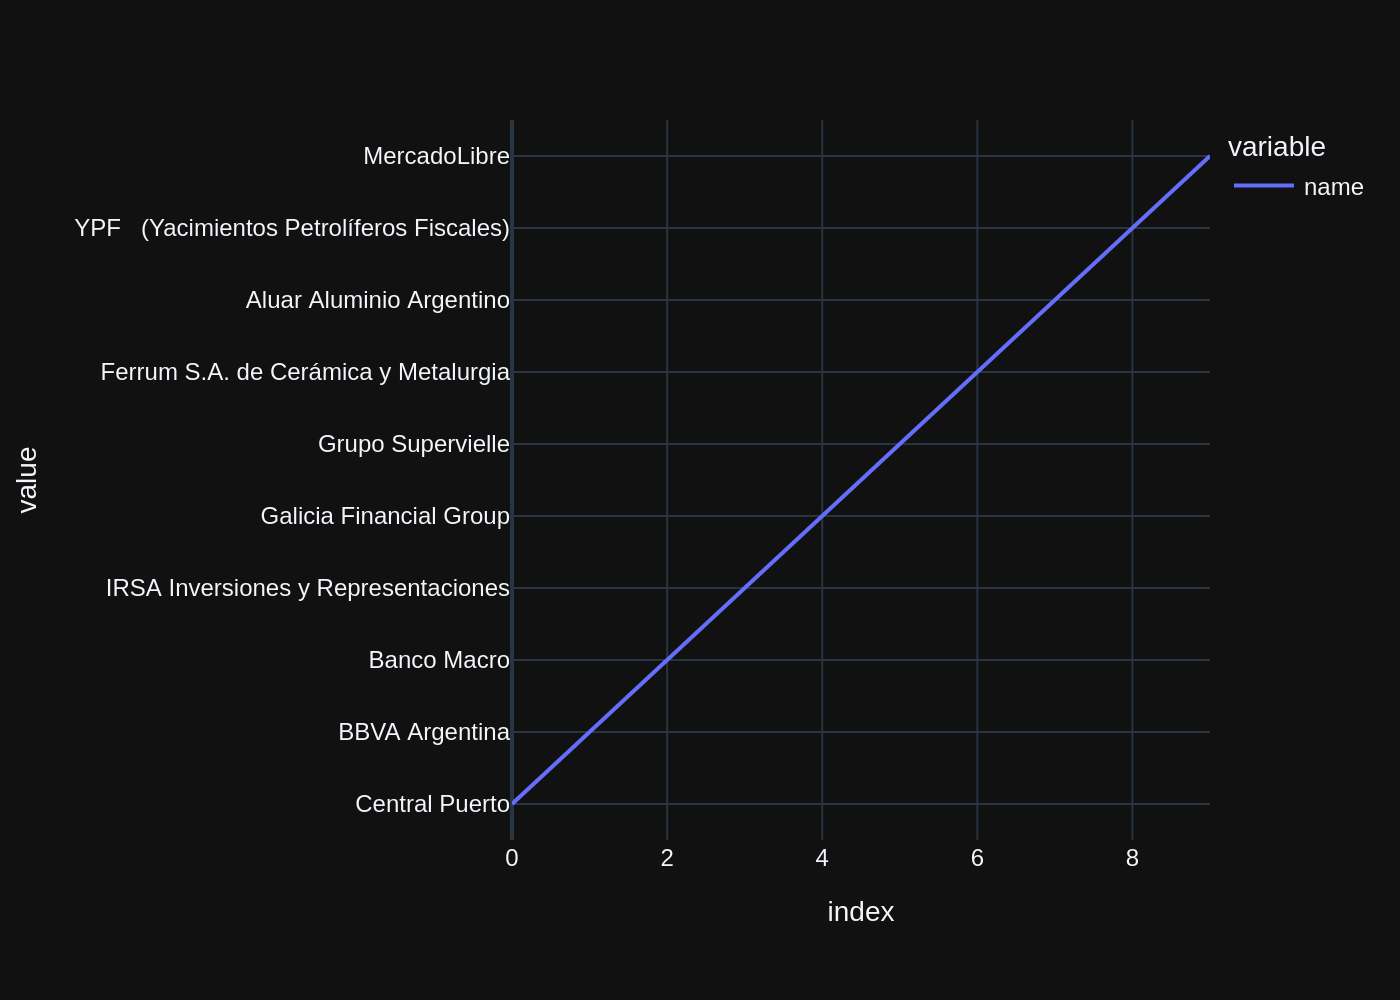

In [20]:
for n, question in enumerate(questions):
    # if n != 4: continue
    # if n > 5: continue

    resp = vn.ask_adaptive(question=question, tag_id=n+2)

### Check completion time

In [21]:
ts_stop = time()
elapsed_time = ts_stop - ts_start
print(f"Completed tests:\n================\n run on host '{hostname}' \n with LLM model '{model_name}' \n took {elapsed_time:.2f} sec")

Completed tests:
 run on host 'papa-game' 
 with LLM model 'deepseek-coder-v2' 
 took 1789.61 sec
